## Illusory contours, intensity/exposure invariance, no need for precision weighting!

Scaling input signal's intensity, not value, e.g. a dim or bright sin wave between 1 and -1.

In [106]:
# %%
import torch
from torch import nn
import pdb
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import random
%matplotlib inline

from scipy.stats import norm

def normal_distribution(n, mean, var=0.05):
  x = norm.pdf(np.arange(0, 1, 1.0 / n), mean, var)
  x = x / np.sum(x)
  return torch.tensor(x).float()

def bhattacharya_distance(hist1,  hist2):
  hist1[hist1<0] = 0
  hist2[hist2<0] = 0

  a = 1 / (np.sum(hist1, axis=1) * np.sum(hist2, axis=1))
  b = np.sum(np.sqrt(hist1 * hist2), axis=1)
  return np.sqrt(1-a*b)

def imshow(title, image, vmin=0, vmax=1):
  plt.figure(figsize=figsize)
  #plt.title("{2} [{0}, {1}]".format(np.amin(image), np.amax(image), title))
  plt.title(title)
  plt.imshow(image, cmap='gray', vmin=vmin, vmax=vmax)
  plt.show()
    
def plot_errors(e):
    imshow('prediction errors', e, vmin=None, vmax=None)

    abs_errors = np.abs(e)
    imshow('abs_errors', abs_errors, vmin=None, vmax=None)

    positive_errors = errors.copy()
    positive_errors[positive_errors<0] = 0
    imshow('positive_errors', positive_errors, vmin=None, vmax=None)

    negative_errors = errors.copy()
    negative_errors[negative_errors>0] = 0
    negative_errors = negative_errors * -1
    imshow('negative_errors', negative_errors, vmin=None, vmax=None)

def sigmoid_array(x):                                        
    return 1 / (1 + np.exp(-x))

# signal is t_steps X quantization
def precision(signal):
    normalized = sigmoid_array(signal)
    return np.max(normalized, axis=0) * 4 - 2

figsize=(15,5)
quantization = 20

## Training pattern: sin() with a bit of noise, normal distribution around mean

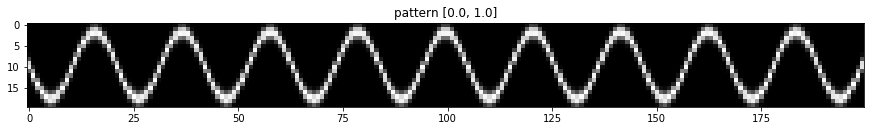

In [84]:
pattern_length = 200
pattern_floats = torch.tensor((np.sin(np.arange(pattern_length) * 0.30) + 1.2 + np.random.sample(int(pattern_length)) * 0) / 2.5).float()
pattern = torch.stack([normal_distribution(quantization, val, var=0.05) for val in pattern_floats])
pattern = pattern / pattern.max().item() # normailze to probability distribution, i.e. sum = 1.0

imshow('pattern', pattern.t().numpy())

## Train an RNN to predict pattern
Use a random intensity value between 0 and 1 for each epoch.

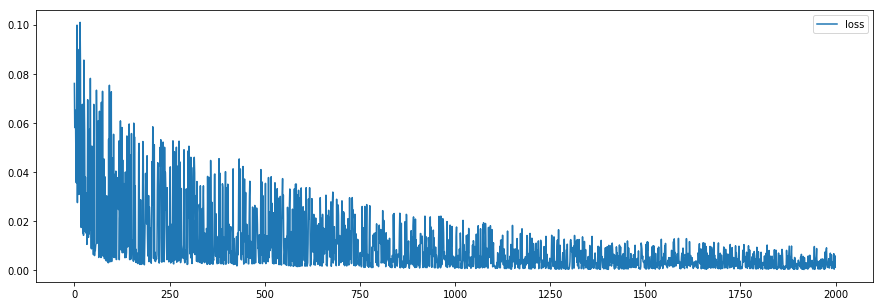

In [97]:
# %%
t_sample = 30
batch_size = pattern_length - t_sample - 1
input = torch.stack([pattern[i:i+t_sample] for i in np.arange(batch_size)])
target = torch.stack([pattern[i+1:i+t_sample+1] for i in np.arange(batch_size)])

hidden_size = t_sample

# %%
num_layers=10
rnn = nn.RNN (
  input_size=quantization,
  hidden_size=quantization,
  num_layers=num_layers,
  nonlinearity='tanh',
  batch_first=True
)

learning_rate = 0.0005
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
epoch = 0
losses = []
while epoch < 2000:
  scale = random.random()
  rnn.zero_grad()
  state = torch.zeros(num_layers, batch_size, quantization)
  out, state = rnn(input * scale, state)
  # out = linear(out)
  # print('out', out)
  # print('state', state)
  #torch.nn.functional.relu_(out)
  loss = torch.nn.functional.mse_loss(out, target * scale)
  loss.backward()
  optimizer.step()
  # print('loss', loss)
  losses.append(loss)
  epoch += 1

plt.figure(figsize=figsize)
plt.plot(losses, label='loss')
plt.legend()
plt.show()

## Test with training pattern

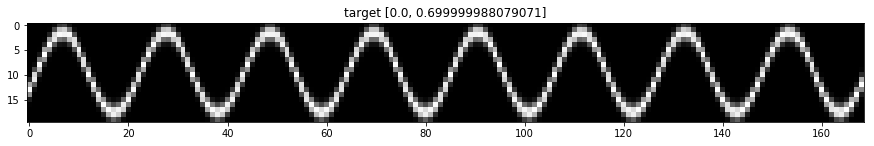

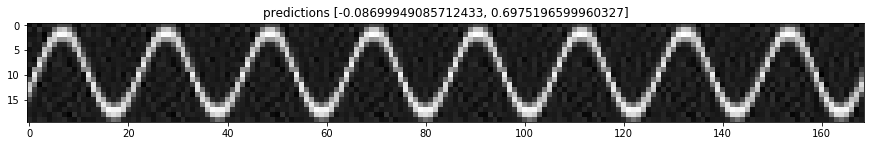

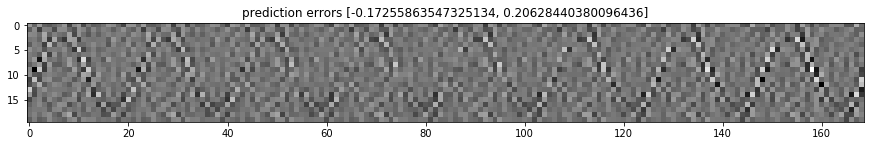

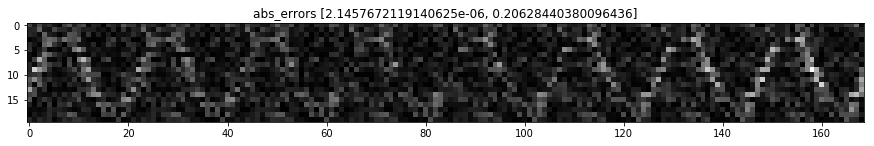

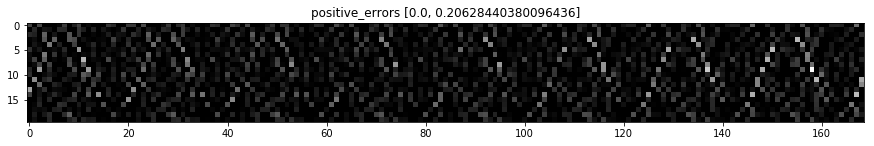

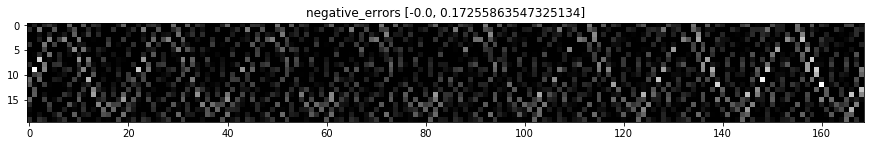

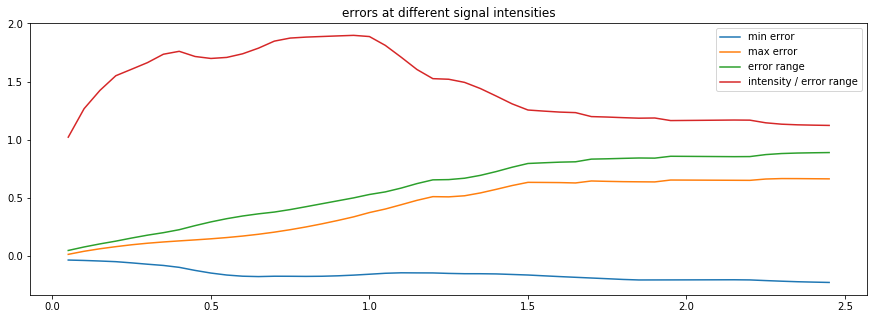

In [98]:
# def sharpen_predictions(preds):
#     max = np.max(preds, axis=0)
#     avg = np.mean(preds, axis=0)
#     preds = preds - avg
#     preds[preds<0] = 0
#     preds = preds * max / (max - avg) 
#     return preds

scale = 0.7
target_predictions = target[:, -1, :].t().numpy() * scale
target_predictions[target_predictions > 1] = 1
imshow('target', target_predictions, vmin=None, vmax=None)

scaled_input = input * scale
scaled_input[scaled_input > 1] = 1
state = torch.zeros(num_layers, batch_size, quantization)
out, state = rnn(scaled_input, state)

predictions = out[:, -1].detach().numpy()
predictions = predictions.transpose()
imshow('predictions', predictions, vmin=None, vmax=None)

# predictions = sharpen_predictions(predictions)
# imshow('sharpened predictions', predictions, vmin=None, vmax=None)

errors = target_predictions - predictions
plot_errors(errors)

error_min = []
error_max = []

r = np.arange(0.05, 2.5, 0.05)
for scale in r:
    scaled_input = input * scale
    scaled_input[scaled_input > 1] = 1

    state = torch.zeros(num_layers, batch_size, quantization)
    out, state = rnn(scaled_input, state)

    predictions = out[:, -1].detach().numpy()
    predictions = predictions.transpose()

    target_predictions = target[:, -1, :].t().numpy() * scale
    target_predictions[target_predictions > 1] = 1

    errors = target_predictions - predictions
    error_min.append(np.min(errors))
    error_max.append(np.max(errors))

error_range = np.asarray(error_max) - np.asarray(error_min)
plt.figure(figsize=figsize)
plt.title("errors at different signal intensities")
plt.plot(r, error_min, label="min error")
plt.plot(r, error_max, label="max error")
plt.plot(r, error_range, label="error range")
plt.plot(r, np.asarray([1.0 if i > 1 else i for i in r]) / error_range, label="intensity / error range")
plt.legend()
plt.show()



X axis shows intensity of signal. The network trained within intensity range (0, 1].

The 'intensity / error range' curve above indicates that at low intensity levels, predictions have low signal to noise ratio. The following extrapolations could be made -
- in low light/exposure condition, predictions are less precise
- precision improves with brighter exposure conditions
- over-exposure also leads to less precision
- optimial exposure conditions are near 60-80% intensity

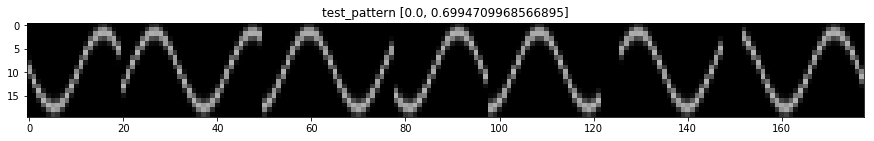

In [99]:
# %%
test_pattern = torch.cat([pattern[0:int(pattern_length*0.10)], pattern[int(pattern_length*0.15):int(pattern_length*0.30)], pattern[int(pattern_length*0.45):int(pattern_length*0.59)], pattern[int(pattern_length*0.85):int(pattern_length*0.95)], pattern[int(pattern_length*0.55):int(pattern_length*0.95)]]) * 0.7
# blank out parts of the signal to observe illusory contours
test_pattern[122:126, :] = 0
test_pattern[148:152, :] = 0

test_pattern_length = test_pattern.shape[0]
imshow('test_pattern', test_pattern.t().numpy())
test_batch_size = test_pattern_length - t_sample - 1
test_input = torch.stack([test_pattern[i:i+t_sample] for i in np.arange(test_batch_size)])
test_target = torch.stack([test_pattern[i+1:i+t_sample+1] for i in np.arange(test_batch_size)])

## Sample output of RNN

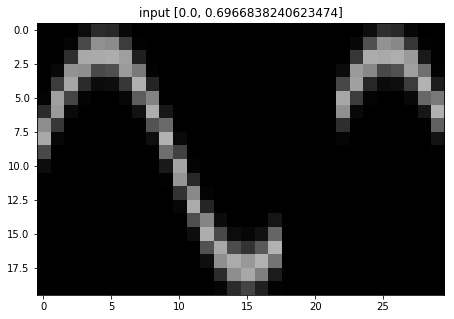

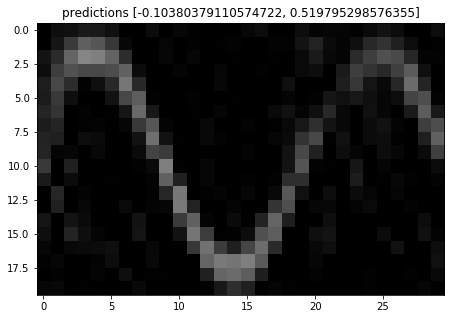

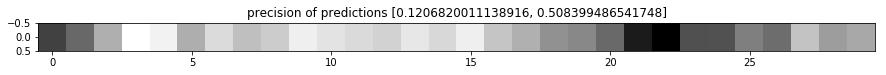

In [100]:
# %%
state = torch.zeros(num_layers, test_batch_size, quantization)
out, state = rnn(test_input * 0.7, state)
#torch.nn.functional.relu_(out)

index = 104
predictions = out[index].detach().t().numpy()
imshow('input', test_input[index].detach().t().numpy())
imshow('predictions', predictions)
imshow('precision of predictions', [precision(predictions)], vmin=None, vmax=None)

Notice illusory contour with slightly weaker precision

## Predictions, precision weighting

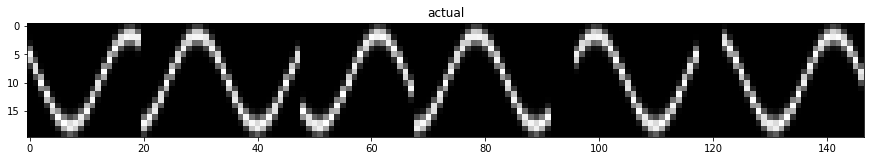

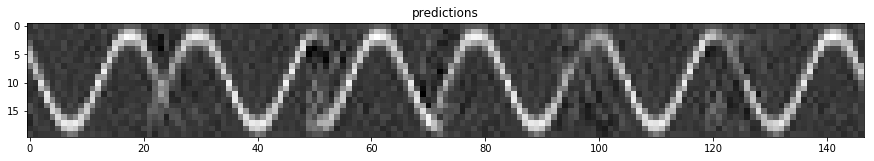

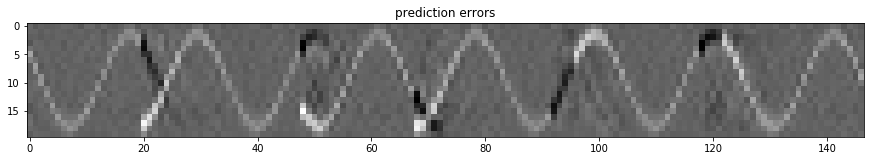

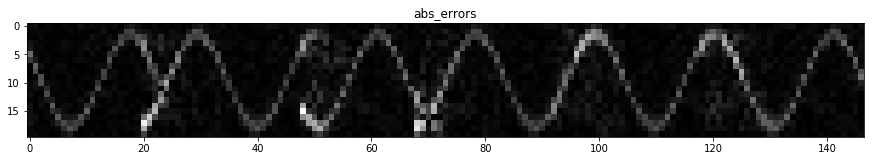

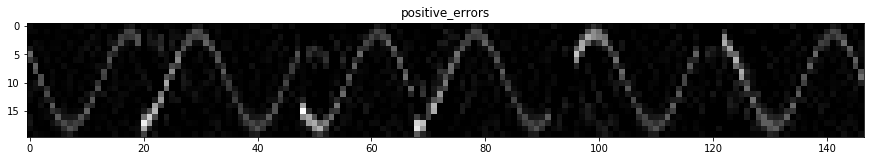

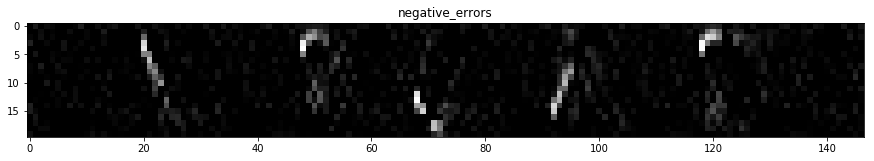

In [107]:
target_predictions = test_target[:, -1, :].t().numpy()
imshow('actual', target_predictions, vmin=None, vmax=None)

# last entry in out is the prediction
predictions = out[:, -1].detach().numpy()
#predictions[predictions<0] = 0
predictions = predictions.transpose()
imshow('predictions', predictions, vmin=None, vmax=None)

#predictions = predictions - np.min(predictions, 0)
#imshow('normalized predictions', predictions, vmin=None, vmax=None)

errors = target_predictions - predictions
plot_errors(errors)



Predictions errors -
- show negative (dark) 'illusory contours', expected signal that was not received
- when there is abrupt change in sensory input, positive (light) errors indicate the signal that was received
- after illusory contours, we notice positive (light) error. This is most likely an artefact caused by not using the predictions as part of future input to the RNN, i.e. we did not allow the RNN to hallucinate. We will need an online method to integrate predictions and sensory input at each time step, to be used for predictions in the next time step.

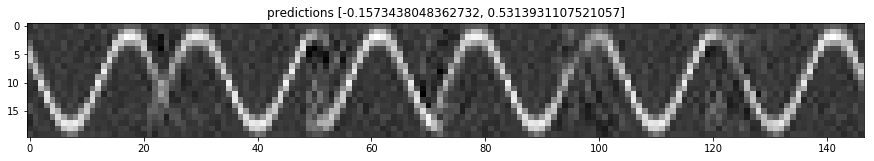

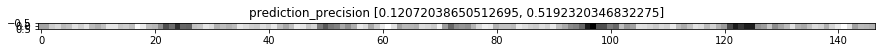

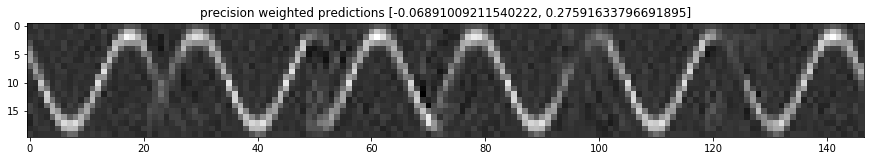

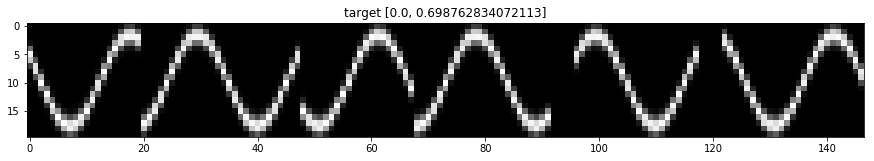

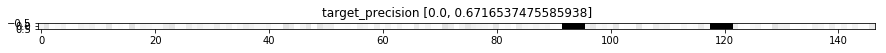

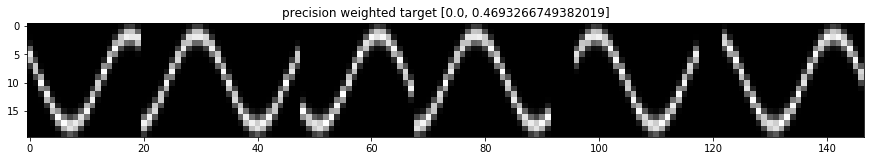

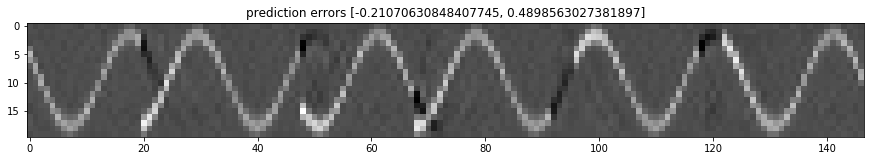

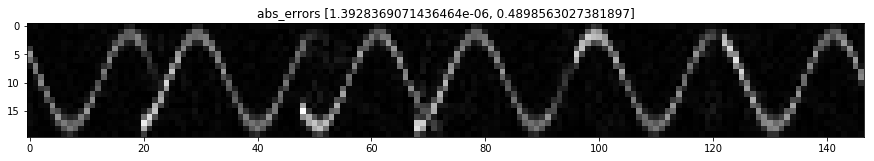

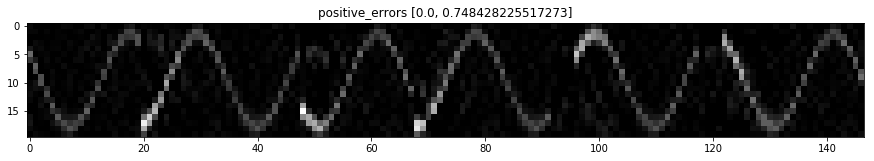

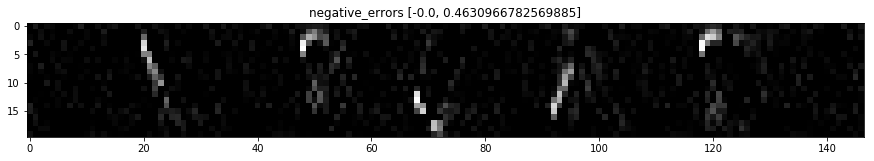

In [102]:

imshow('predictions', predictions, vmin=None, vmax=None)

prediction_precision = precision(predictions)
imshow('prediction_precision', [prediction_precision], vmin=None, vmax=None)

precision_weighted_predictions = predictions * prediction_precision
imshow('precision weighted predictions', precision_weighted_predictions, vmin=None, vmax=None)


imshow('target', target_predictions, vmin=None, vmax=None)

target_precision = precision(target_predictions)
imshow('target_precision', [target_precision], vmin=None, vmax=None)

precision_weighted_target = target_predictions * target_precision
imshow('precision weighted target', precision_weighted_target, vmin=None, vmax=None)



precision_weighted_errors = target_predictions * target_precision - precision_weighted_predictions
#precision_weighted_errors[precision_weighted_errors<0] = 0
plot_errors(precision_weighted_errors)


Ah ha! The predictions are ALREADY precision weighted because by virtue of having low precision, the histogram will be flatter (assuming intensity preservation). If we were considering the just the expectation, then we would have to weight it down somehow for low precision, but here we have a whole PDF. I am concluding that there is no need for additional precision weighting for this representation.

That should also apply to EXPECTED precision indicated by top down predictions, but we will cross that bridge when we get there.

## Next steps
- train f() using a combination of mu_bar and mu
- train g(hidden state, mu-(mu_bar + mu_hat))
- use 2D sample instaead of single point
- use multiple layers